In [16]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Concatenate, Reshape, AveragePooling2D
from keras.applications.densenet import DenseNet121, preprocess_input
from keras import Input
from keras.initializers import he_normal
from keras.callbacks import EarlyStopping, ModelCheckpoint
from PIL import Image
from tensorflow.keras.optimizers import Adam, RMSprop
from shutil import rmtree
from itertools import cycle
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, average_precision_score
import seaborn as sb
import tensorflow as tf
import matplotlib.cm as cm
import re

# Project variables

In [17]:
m_name = "densenet_2_classes_bce_test3"
p_dir = os.path.join("../img models", m_name)

In [18]:
def create_dir(dir_path: str):
    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

In [19]:
def clear_dir(dir_path: str):
    for item in os.listdir(dir_path):
        fp = os.path.join(dir_path, item)
        if os.path.isfile(fp):
            os.remove(fp)
        if os.path.isdir(fp):
            rmtree(fp)

In [20]:
create_dir(p_dir)
clear_dir(p_dir)

# Read and transform scraped dataframes

In [21]:
fp = "../scraped data"

channels = pd.read_pickle(os.path.join(fp, "channels.pkl"))
videos = pd.read_pickle(os.path.join(fp, "videos.pkl"))

In [22]:
def transform_channels(df: pd.DataFrame) -> pd.DataFrame:
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type into int64
    fields = ["video_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["subscriber_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    # Add of channel in months
    df["age_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
        
    # Drop unnecessary fields
    df.drop(columns=["custom_url", "country"] + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    # Remove channels without subscriber_count
    df = df.loc[df.subscriber_count.notnull(), :]
    
    return df

In [23]:
def transform_videos(df: pd.DataFrame) -> pd.DataFrame:    
    # Date string into proper date
    df.published = pd.to_datetime(df.published)
    
    # Convert field type to bool
    fields = ["broadcast"]
    df.loc[:, fields] = df.loc[:, fields].astype("bool")
    
    # Convert field type into int64
    fields = ["category_id"]
    df.loc[:, fields] = df.loc[:, fields].astype("int64")
    
    # Convert field type into float64
    fields = ["comment_count", "dislike_count", "like_count", "view_count"]
    df.loc[:, fields] = df.loc[:, fields].astype("float64")
    
    df["published_mth"] = (pd.to_datetime("today", utc=True).year - df.published.dt.year) * 12 \
        + (pd.to_datetime("today", utc=True).month - df.published.dt.month)
    df["title_len"] = df.title.str.len()
    
    df.drop(columns=["favorite_count", "broadcast", "audio_language", "comment_count", "category_id"] \
            + [c for c in df.columns if c.startswith("thumbnail")], inplace=True)
    
    df = df.loc[df.like_count.notnull() & df.dislike_count.notnull() & df.view_count.notnull(), :]
    
    return df

In [24]:
channels_trans = transform_channels(channels)
videos_trans = transform_videos(videos)
combo = videos_trans.merge(channels_trans[["id", "view_count","published", "age_mth", "subscriber_count",
                                             "video_count"]], 
                           how="inner", left_on="channel_id", right_on="id", suffixes=["_video", "_channel"])
combo["ln_vc_norm"] = np.log(combo.video_count / combo.subscriber_count)

# Define categories

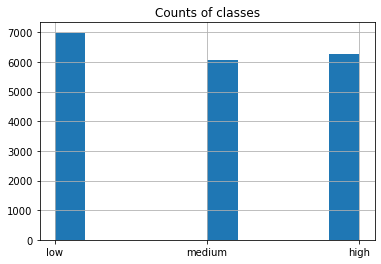

In [25]:
cat_lbl = ["low", "medium", "high"]
combo.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl), labels=cat_lbl, precision=6)
combo.sort_values(by=["qtl"]).qtl.hist()
plt.title("Counts of classes")
plt.show()

# Split dataset (use only top and bottom quartile data)

In [26]:
cat_lbl = ["low", "high"]
combo = combo.loc[combo.qtl.isin(cat_lbl)]
combo.qtl = combo.qtl.cat.remove_unused_categories()

y = combo.qtl
x = combo.loc[:, [c for c in combo.columns if c != "qtl"]]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=4711)

x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train.shape[0], x_val.shape[0], x_test.shape[0])

7951 2651 2651


# Build the model

In [27]:
def create_model():
    
    inp = Input(shape=(120, 90, 3))
    
    base_model = DenseNet121(weights="imagenet", include_top=False, input_tensor=inp)
    base_model.trainable = False
    x = base_model.output
    
    x = AveragePooling2D()(x)
    x = BatchNormalization()(x)
    x = Flatten()(x)
    x = Dropout(0.5)(x)
    x = Dense(1024, activation="relu")(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    out = Dense(len(cat_lbl), activation="sigmoid")(x)
    
    model = Model(base_model.input, out)
    
    model.compile(loss='binary_crossentropy', 
                  optimizer=Adam(learning_rate=0.0005), 
                  metrics=["accuracy"])
    
    return model

In [28]:
model = create_model()
# model.summary()

# Prepare ImageDataGenerators

In [29]:
def train_generator(X, y, img_dir, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
#                                  rotation_range=15,
#                                  width_shift_range=0.15,
#                                  height_shift_range=0.15,
#                                  zoom_range=0.2,
#                                  horizontal_flip=True,
#                                  dtype=np.float32
                                )
    gen = datagen.flow_from_dataframe(dataframe=combo,
                                      directory=img_dir,
                                      x_col="file_name", 
                                      y_col="qtl",
                                      class_mode="categorical",
                                      color_mode="rgb",
                                      target_size=(120, 90),
                                      shuffle=True,
                                      batch_size=batch_size                                      
                                     )
    return gen

def val_generator(X, y, img_dir, batch_size):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input
    )
    gen = datagen.flow_from_dataframe(dataframe=combo,
                                      directory=img_dir,
                                      x_col="file_name", 
                                      y_col="qtl",
                                      class_mode="categorical",
                                      color_mode="rgb",
                                      target_size=(120, 90),
                                      shuffle=True,
                                      batch_size=batch_size                                      
                                     )
    return gen

# Train the model

In [30]:
img_dir = "../images"
batch_size = 64

train_gen = train_generator(x_train, y_train, img_dir, batch_size)
val_gen = val_generator(x_val, y_val, img_dir, batch_size)

metric = "val_loss"

es = EarlyStopping(monitor=metric, 
                   mode="min", 
                   patience=5, 
                   restore_best_weights=True)

checkpoint = ModelCheckpoint(os.path.join(p_dir, "{}".format(m_name)), 
                             monitor=metric, 
                             verbose=2, 
                             save_best_only=True, 
                             save_weights_only=True, 
                             mode='min')

hist = model.fit(train_gen,
                 epochs=200,
                 validation_data=val_gen,
                 verbose=1,
                 callbacks=[checkpoint, es])

Found 7951 validated image filenames belonging to 2 classes.
Found 2651 validated image filenames belonging to 2 classes.
Epoch 1/200
125/125 [==============================] - 16s 83ms/step - loss: 0.5533 - accuracy: 0.7814 - val_loss: 0.3674 - val_accuracy: 0.8480

Epoch 00001: val_loss improved from inf to 0.36745, saving model to ../img models/densenet_2_classes_bce/densenet_2_classes_bce
Epoch 2/200
125/125 [==============================] - 9s 70ms/step - loss: 0.4141 - accuracy: 0.8290 - val_loss: 0.3171 - val_accuracy: 0.8619

Epoch 00002: val_loss improved from 0.36745 to 0.31712, saving model to ../img models/densenet_2_classes_bce/densenet_2_classes_bce
Epoch 3/200
125/125 [==============================] - 9s 70ms/step - loss: 0.3685 - accuracy: 0.8471 - val_loss: 0.3087 - val_accuracy: 0.8638

Epoch 00003: val_loss improved from 0.31712 to 0.30869, saving model to ../img models/densenet_2_classes_bce/densenet_2_classes_bce
Epoch 4/200
125/125 [=============================

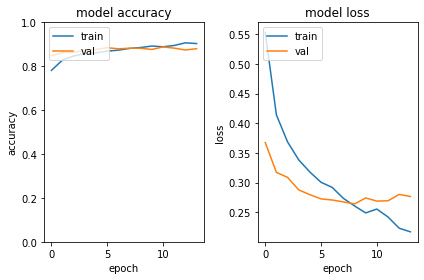

In [31]:
fig, axs = plt.subplots(1, 2)

axs[0].plot(hist.history["accuracy"])
axs[0].plot(hist.history["val_accuracy"])
axs[0].set_title("model accuracy")
axs[0].set_ylabel("accuracy")
axs[0].set_xlabel("epoch")
axs[0].set_ylim(0, 1)
axs[0].legend(["train", "val"], loc="upper left")

axs[1].plot(hist.history["loss"])
axs[1].plot(hist.history["val_loss"])
axs[1].set_title("model loss")
axs[1].set_ylabel("loss")
axs[1].set_xlabel("epoch")
# axs[1].set_ylim(0, 1)
axs[1].legend(["train", "val"], loc="upper left")

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(p_dir, "accuracy_loss.jpg"))

# Sample images per category

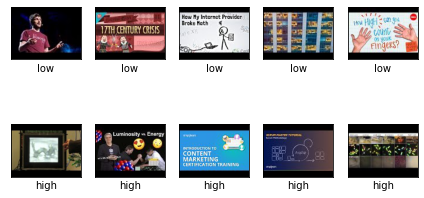

<Figure size 432x288 with 0 Axes>

In [116]:
s = combo.loc[combo["id_video"].isin(x_train["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=15))

n_images = 5
fig, axs = plt.subplots(len(cat_lbl), n_images)
i = 0

for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // n_images, i % n_images].imshow(img)
    axs[i // n_images, i % n_images].xaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].xaxis.set_ticks([])
    axs[i // n_images, i % n_images].set_xlabel(row["qtl"])
    axs[i // n_images, i % n_images].yaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.show()
plt.suptitle("Sample images - training data")
fig.savefig(os.path.join(p_dir, "sample_images.jpg"))

# Confusion matrix

In [33]:
# model = load_model(os.path.join(p_dir, "{}".format(m_name)))
model.load_weights(os.path.join(p_dir, "{}".format(m_name)))

In [36]:
def test_generator(X, y, img_dir):
    combo = pd.concat([X, y], axis="columns")
    combo["file_name"] = combo.id_video + ".jpg"
    datagen = ImageDataGenerator(preprocessing_function=preprocess_input
                                )
    gen = datagen.flow_from_dataframe(dataframe=combo,
                                      directory=img_dir,
                                      x_col="file_name", 
                                      y_col="qtl",
                                      class_mode="categorical",
                                      color_mode="rgb",
                                      target_size=(120, 90),
                                      shuffle=False,
                                      batch_size=1                                      
                                     )
    return gen

## Validation dataset (in_sample)

In [85]:
img_dir = "../images"

x_val = pd.read_pickle(os.path.join(p_dir, "x_val.pkl"))
y_val = pd.read_pickle(os.path.join(p_dir, "y_val.pkl"))
val_gen = test_generator(x_val, y_val, img_dir)
y_val_prob = model.predict(val_gen, steps=y_val.shape[0])
y_pred = np.argmax(y_val_prob, axis=1)
cls_lbl = dict([(v, k) for k, v in val_gen.class_indices.items()])
y_pred = pd.Series([cls_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

Found 2651 validated image filenames belonging to 2 classes.


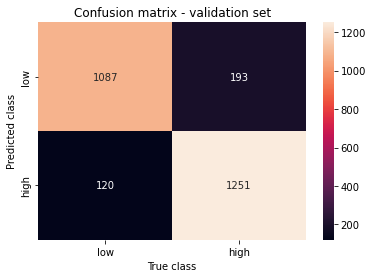

Accuracy: 0.88
Micro precision: 0.88
Micro recall: 0.88
Micro F1-score: 0.88
Macro precision: 0.88
Macro recall: 0.88
Macro F1-score: 0.88
Weighted precision: 0.88
Weighted recall: 0.88
Weighted F1-score: 0.88
              precision    recall  f1-score   support

         low       0.90      0.85      0.87      1280
        high       0.87      0.91      0.89      1371

    accuracy                           0.88      2651
   macro avg       0.88      0.88      0.88      2651
weighted avg       0.88      0.88      0.88      2651



In [86]:
cmtx = confusion_matrix(y_val, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_val.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - validation set")
plt.savefig(os.path.join(p_dir, "confusion_matrix_val.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_val, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_val, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_val, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_val, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_val, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_val, y_pred, average="weighted")))

print(classification_report(y_val, y_pred, target_names=cat_lbl))

## Test dataset (out-of_sample)

In [87]:
img_dir = "../images"

x_test = pd.read_pickle(os.path.join(p_dir, "x_test.pkl"))
y_test = pd.read_pickle(os.path.join(p_dir, "y_test.pkl"))
test_gen = test_generator(x_test, y_test, img_dir)
y_pred_prob = model.predict(test_gen, steps=y_test.shape[0])
y_pred = np.argmax(y_pred_prob, axis=1)
cls_lbl = dict([(v, k) for k, v in test_gen.class_indices.items()])
y_pred = pd.Series([cls_lbl[i] for i in y_pred]).astype("category").cat.reorder_categories(cat_lbl)

Found 2651 validated image filenames belonging to 2 classes.


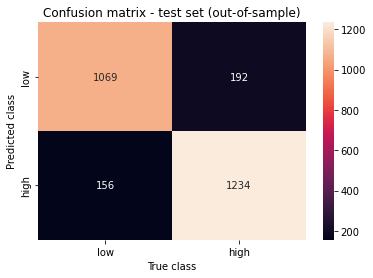

Accuracy: 0.87
Micro precision: 0.87
Micro recall: 0.87
Micro F1-score: 0.87
Macro precision: 0.87
Macro recall: 0.87
Macro F1-score: 0.87
Weighted precision: 0.87
Weighted recall: 0.87
Weighted F1-score: 0.87
              precision    recall  f1-score   support

         low       0.87      0.85      0.86      1261
        high       0.87      0.89      0.88      1390

    accuracy                           0.87      2651
   macro avg       0.87      0.87      0.87      2651
weighted avg       0.87      0.87      0.87      2651



In [88]:
cmtx = confusion_matrix(y_test, y_pred)
sb.heatmap(cmtx, annot=True, fmt="d", xticklabels=y_test.cat.categories, yticklabels=y_pred.cat.categories)
plt.xlabel("True class")
plt.ylabel("Predicted class")
plt.title("Confusion matrix - test set (out-of-sample)")
plt.savefig(os.path.join(p_dir, "confusion_matrix.jpg"))
plt.show()

print("Accuracy: {:0.2f}".format(accuracy_score(y_test, y_pred)))

print("Micro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="micro")))
print("Micro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="micro")))
print("Micro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="micro")))

print("Macro precision: {:0.2f}".format(precision_score(y_test, y_pred, average="macro")))
print("Macro recall: {:0.2f}".format(recall_score(y_test, y_pred, average="macro")))
print("Macro F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="macro")))

print("Weighted precision: {:0.2f}".format(precision_score(y_test, y_pred, average="weighted")))
print("Weighted recall: {:0.2f}".format(recall_score(y_test, y_pred, average="weighted")))
print("Weighted F1-score: {:0.2f}".format(f1_score(y_test, y_pred, average="weighted")))

print(classification_report(y_test, y_pred, target_names=cat_lbl))

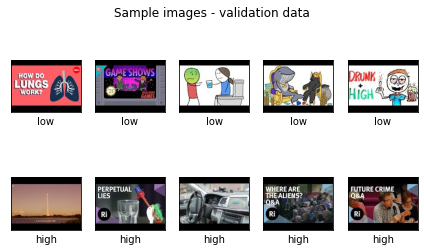

In [115]:
s = combo.loc[combo["id_video"].isin(x_val["id_video"]), ["id_video", "qtl"]].groupby("qtl", as_index=False).apply(lambda x: x.sample(5, random_state=118))

n_images = 5
fig, axs = plt.subplots(len(cat_lbl), n_images)
i = 0

for idx, row in s.iterrows():
    img = Image.open(os.path.join(img_dir, "{}.jpg".format(row["id_video"])))
    axs[i // n_images, i % n_images].imshow(img)
    axs[i // n_images, i % n_images].xaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].xaxis.set_ticks([])
    axs[i // n_images, i % n_images].set_xlabel(row["qtl"])
    axs[i // n_images, i % n_images].yaxis.set_ticklabels([])
    axs[i // n_images, i % n_images].yaxis.set_ticks([])
    i += 1
plt.tight_layout()
plt.suptitle("Sample images - validation data")
plt.show()
fig.savefig(os.path.join(p_dir, "sample_images_val.jpg"))

# ROC Curve

In [37]:
lb = LabelBinarizer()
y_test_no = lb.fit_transform(y_test)
y_pred_no = y_pred_prob[:, 1]
fpr, tpr, thr = roc_curve(y_test_no, y_pred_no)

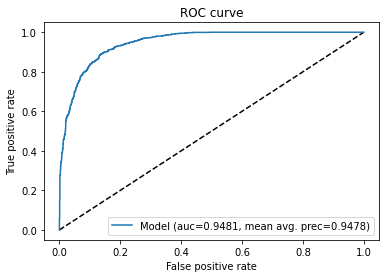

In [38]:
auc_model = auc(fpr, tpr)
mavgp = average_precision_score(y_test_no, y_pred_no)

plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, label="Model (auc={:0.4f}, mean avg. prec={:0.4f})".format(auc_model, mavgp))
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.title("ROC curve")
plt.legend()
plt.savefig(os.path.join(p_dir, "roc-curve.jpg"))
plt.show()

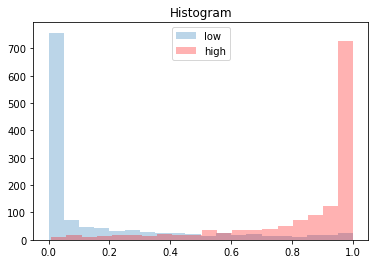

In [39]:
m0 = y_test_no[:, 0] == 0
c0 = y_pred_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_pred_prob[m1, 1]

plt.hist(c0, alpha=0.3, bins=20)
plt.hist(c1, color="red", alpha=0.3, bins=20)
plt.title("Histogram")
plt.legend(cat_lbl)
plt.savefig(os.path.join(p_dir, "histogram.jpg"))
plt.show()

# The same including the middle class

In [40]:
cat_lbl2 = ["low", "medium", "high"]
combo2 = combo.copy()
combo2.loc[:, "qtl"] = pd.qcut(combo.ln_vc_norm, len(cat_lbl2), labels=cat_lbl2, precision=6)

In [41]:
combo2 = combo2.loc[combo2.qtl == "medium", :]
combo2.qtl = combo2.qtl.cat.remove_unused_categories()

y2 = combo2.qtl
x2 = combo2.loc[:, [c for c in combo2.columns if c != "qtl"]]

x_train2, x_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, random_state=42)
x_train2, x_val2, y_train2, y_val2 = train_test_split(x_train2, y_train2, test_size=0.25, random_state=4711)

# x_train.to_pickle(os.path.join(p_dir, "x_train.pkl"))
# y_train.to_pickle(os.path.join(p_dir, "y_train.pkl"))
# x_val.to_pickle(os.path.join(p_dir,"x_val.pkl"))
# y_val.to_pickle(os.path.join(p_dir, "y_val.pkl"))
# x_test.to_pickle(os.path.join(p_dir,"x_test.pkl"))
# y_test.to_pickle(os.path.join(p_dir, "y_test.pkl"))

print(x_train2.shape[0], x_val2.shape[0], x_test2.shape[0])

2424 809 809


In [42]:
test_gen2 = test_generator(x_test2, y_test2, img_dir)
y_pred_prob2 = model.predict(test_gen2, steps=y_test2.shape[0])
y_pred2 = np.argmax(y_pred_prob2, axis=1)
cls_lbl = dict([(v, k) for k, v in test_gen.class_indices.items()])
y_pred = pd.Series([cls_lbl[i] for i in y_pred2]).astype("category").cat.reorder_categories(cat_lbl)

Found 809 validated image filenames belonging to 1 classes.


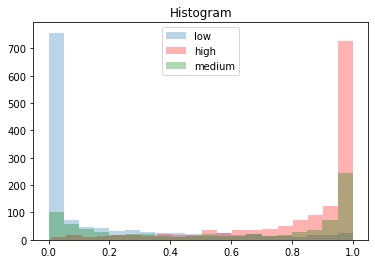

In [43]:
m0 = y_test_no[:, 0] == 0
c0 = y_pred_prob[m0, 1]
m1 = y_test_no[:, 0] == 1
c1 = y_pred_prob[m1, 1]

c2 = y_pred_prob2[:, 1]

plt.hist(c0, alpha=0.3, label="", bins=20)
plt.hist(c1, color="red", alpha=0.3, label="", bins=20)
plt.hist(c2, color="green", alpha=0.3, label="", bins=20)
plt.title("Histogram")
plt.legend(cat_lbl + ["medium"])
plt.savefig(os.path.join(p_dir, "histogram_w_medium.jpg"))
plt.show()

# Grad-CAM class activation visualization

In [44]:
def get_img_array(img_path, size):
    img = load_img(img_path, target_size=size)
    array = img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def create_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    img = load_img(img_path)
    img = img_to_array(img)

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = array_to_img(superimposed_img)

    return superimposed_img

In [45]:
def cam_image(img_dir, id_video, last_cl, alpha=0.4, pred_class:str="low"):
    img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
    img_array = get_img_array(img_path, size=(120, 90))
    model.layers[-1].activation = None
    preds = model.predict(img_array)
    pred_idx = cat_lbl.index(pred_class)
    heatmap = make_gradcam_heatmap(img_array, model, last_cl, pred_idx)
    img = create_gradcam(img_path, heatmap, os.path.join(p_dir, "cam_{}.jpg".format(row["id_video"])), alpha)
    return img

In [46]:
p = re.compile("conv\d+_block\d+_concat")
p2 = re.compile("conv(\d+)_block(\d+)_concat")
conv_layers = dict()
for layer in model.layers:
    if p.match(layer.name):
        m = p2.search(layer.name)
        if m:
            conv_layers[m.group(1)] = m.group(2)

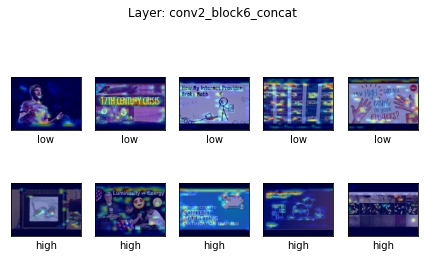

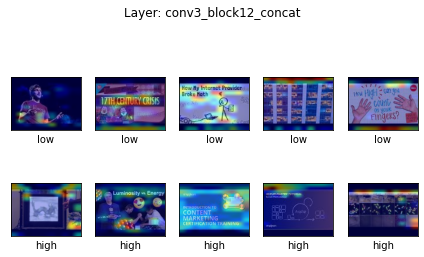

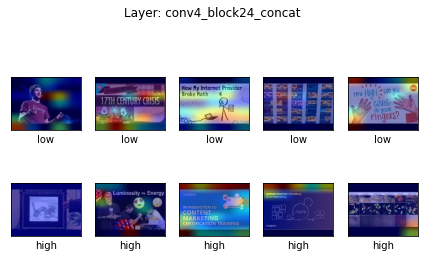

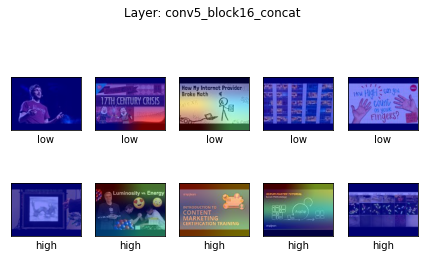

In [47]:
target_names = ["conv{}_block{}_concat".format(k, v) for k, v in conv_layers.items()]
for layer in model.layers:
    if layer.name in target_names:        
        alpha = 0.8

        fig, axs = plt.subplots(len(cat_lbl), 5)
        i = 0
        for idx, row in s.iterrows():
            img_path = os.path.join(img_dir, "{}.jpg".format(row["id_video"]))
            img = cam_image(img_dir, row["id_video"], layer.name, alpha, row["qtl"])
            axs[i // 5, i % 5].imshow(img)
            axs[i // 5, i % 5].xaxis.set_ticklabels([])
            axs[i // 5, i % 5].xaxis.set_ticks([])
            axs[i // 5, i % 5].set_xlabel(row["qtl"])
            axs[i // 5, i % 5].yaxis.set_ticklabels([])
            axs[i // 5, i % 5].yaxis.set_ticks([])
            i += 1
        plt.suptitle("Layer: {}".format(layer.name))
        plt.tight_layout()        
        plt.show()
        fig.savefig(os.path.join(p_dir, "cam_sample_{}.jpg".format(layer.name)))